<a href="https://colab.research.google.com/github/naavaquinn/Fake-News-Detection/blob/main/Nueral_Networks_lab_3_homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image classification with multilayer perceptron (MLP)

**Name**:

In this lab we design and train our first MLP network, and we use it for image classification.

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
import torchvision
import os
import matplotlib.pyplot as plt
import copy

## Dataset

We use the [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset, which is a large image dataset of hand-written digits.

<center><a href="https://en.wikipedia.org/wiki/MNIST_database">
    <img src="https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png"></a></center>

Just like some other widely-used datasets, MNIST can be downloaded directly from Pytorch, and includes specific commands to create a `Dataset` object, thus you don't have to do it manually as we did in lab 1.

In [ ]:
# Dataset repository - remember to change it according to your folder structure
data_dir = '../datasets/'

# Choose one (or several) transform(s) to preprocess the data
# Here, we transform it to torch tensors, and we apply some normalization
data_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize((0.1307,), (0.3081,))])

# Create a Dataset (you can download the data by setting 'download=True')
train_data = torchvision.datasets.MNIST(data_dir, train=True, download=True, transform=data_transforms)
test_data = torchvision.datasets.MNIST(data_dir, train=False, download=True, transform=data_transforms)
num_classes = len(train_data.classes)
print('Number of classes in the dataset:', num_classes)

# We are not going to work with the full dataset (which is quite large), so we only keep small train and test subsets.
train_data = Subset(train_data, torch.arange(500))
test_data = Subset(test_data, torch.arange(50))
print('Number of images in the train dataset', len(train_data))
print('Number of images in the test dataset', len(test_data))

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 10843287.19it/s]


Extracting ../datasets/MNIST/raw/train-images-idx3-ubyte.gz to ../datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1927684.50it/s]

Extracting ../datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ../datasets/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 12798271.20it/s]


Extracting ../datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ../datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 9198710.17it/s]

Extracting ../datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../datasets/MNIST/raw



Number of classes in the dataset: 10
Number of images in the train dataset 500
Number of images in the test dataset 50


torch.Size([1, 28, 28])
Image label= 5


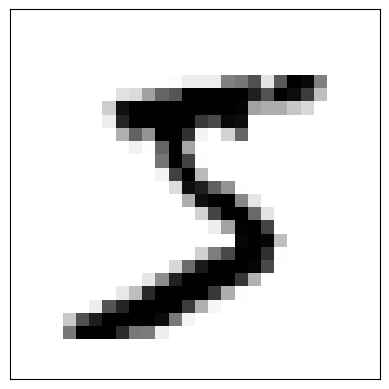

In [ ]:
# Fetch one data pair (one image and the corresponding label)
image, label = train_data[0]
print(image.shape)
print('Image label=', label)

# The size of the image is [1, 28, 28], which corresponds to [num_channels, height, width]
# Indeed, MNIST images are in black-and-white (or grey scale) so there is only 1 color channel.
# To plot this image, let's remove this channel dimension by using squeeze()
plt.figure()
plt.imshow(image.squeeze(), cmap='gray_r')
plt.xticks([]), plt.yticks([])
plt.show()

In [ ]:
# TO DO:
# - create two dataloaders (for the training and testing subsets) with a batch size of 8
# - print the number of batches in the training subset
batch_size = 8
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Print number of batches in the training subset
print(f'number of batches: {len(train_dataloader)}')

number of batches: 63


In [ ]:
# Get a batch of images and corresponding labels from the train dataloader
batch_example = next(iter(train_dataloader))
image_batch_example = batch_example[0]
labels_batch_example = batch_example[1]

# Print the size of the batch of images and labels
print(image_batch_example.shape)
print(labels_batch_example.shape)

torch.Size([8, 1, 28, 28])
torch.Size([8])


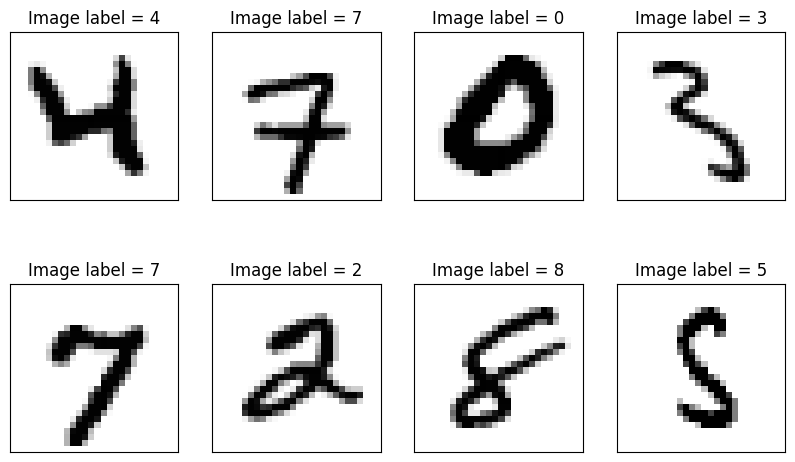

In [ ]:
# Plot the images in the batch (along with the corresponding label)
plt.figure(figsize = (10,6))
for ib in range(batch_size):
    plt.subplot(batch_size // 4, 4, ib+1)
    plt.imshow(image_batch_example[ib, :].squeeze(), cmap='gray_r')
    plt.xticks([]), plt.yticks([])
    plt.title('Image label = ' + str(labels_batch_example[ib].item()))
plt.show()

## MLP network

A typical MLP network is composed of several layers:

- an *input* layer, which takes a batch of vectors and computes the first hidden representation.
- one or several *hidden* layers.
- an *output* layer, which computes the output of the network.

Each layer consists of a linear part and a non-linear *activation* functions (remember lab 2). There are many non-linear activation functions in Pytorch, check the [documentation](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity) for a complete overview. A network is said to be *deep* if it has at least 3 layers (input, at least one hidden, and output).

<center><a href="https://www.researchgate.net/publication/309592737_Classification_of_VoIP_and_non-VoIP_traffic_using_machine_learning_approaches">
    <img src="https://www.researchgate.net/profile/Mouhammd-Alkasassbeh/publication/309592737/figure/fig2/AS:423712664100865@1478032379613/MultiLayer-Perceptron-MLP-sturcture-334-MultiLayer-Perceptron-Classifier-MultiLayer.png"></a></center>

**Note**: Since an MLP manipulates vectors (= 1D-tensors) as inputs, in image processing we first have to transform our images into vectors. For instance, if a black-and-white image is a (3D) tensor of size `[1, 28, 28]`, then we have to reshape it into a tensor of size `[1x28x28] = [784]`.


### Example

First, let's write each layer individually and apply them on the example batch `image_batch_example`.

In [ ]:
# TO DO: reshape image_batch_example into a batch of vectors (=vectorized images):
# 'image_batch_example' has size [batch_size, 1, 28, 28]
# 'vectorized_batch' should have size [batch_size, 1*28*28]
# Reshape the batch of images into a batch of vectors
image_batch_example = image_batch_example.reshape(image_batch_example.shape[0], -1)
print(image_batch_example.shape)


torch.Size([8, 784])


In [ ]:
#now we create the input layer (linear and activation) and we pass the vectorized batch through it
input_size = image_batch_example.shape[-1]
hidden_size = 10
input_layer = nn.Sequential(nn.Linear(input_size, hidden_size), nn.Sigmoid())
y = input_layer(image_batch_example)
print(y.shape)

torch.Size([8, 10])


Now, let's create the hidden and output layers.
- the hidden layer goes from `hidden_size` to `hidden_size`, and uses a Sigmoid activation function.
- the output layer goes from `hidden_size` to `output_size`, and uses no activation function.

**Note**: the output size is the number of classes in the dataset.

In [ ]:
# TO DO:
# - create the hidden and output layers
# - apply them to y to compute the output 'out'
# - print the size of 'out'
hidden_size = 10
output_size = num_classes
hidden_layer = nn.Sequential(nn.Linear(hidden_size, hidden_size), nn.Sigmoid())#define the hidden and output layers
output_layer = nn.Linear(hidden_size, output_size)
print(y.shape)
out = output_layer(hidden_layer(y))
print(out.shape)


torch.Size([8, 10])
torch.Size([8, 10])


From what we have done above, two important remarks can be made:

- The output `out` has size `[batch_size, num_classes]` while the true labels `labels_batch_example` has size `[batch_size]`. This is because `out` contains a predicted probability for each class, while `labels_batch_example` simply contains the true labels.
- In classification tasks, we want to output *probabilities per class*. However, nothing ensures that `out` corresponds to probabilities, since it is not normalized and we didn't use any output activation function (values can be negative and not sum up to 1).

However, when training a classification network, we generally use the [Cross Entropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss) loss function, which alleviates these two issues. This loss is optimized for handling true labels instead of true probabilities per class, so you don't have to worry about it. Besides, it will automatically apply a [Softmax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html) non-linearity to the predicted outputs, in order to normalize them as probabilities per class.

**Note**: Instead of Cross Entropy, you can use the [Negative log-likelihood](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html#torch.nn.NLLLoss) similarly. It will also solve the first problem, but then you need to manually add a [log Softmax](https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax.html#torch.nn.LogSoftmax) as output activation to normalize the outputs.

In [ ]:
#choose Cross Entropy as loss function
loss_fn = nn.CrossEntropyLoss()

#compute the error between the predicted labels out and true labels labels batch example
loss_batch = loss_fn(out, labels_batch_example)
print(loss_batch.item())

2.4064226150512695


### General module

Now, let's create a general MLP classification network. It's a python class that inherits from the general `nn.Module` object, and it should contain at least 2 methods:

- `__init__`, which initializes the network when instanciated (creates all the layers and stores some useful parameters if needed).
- `forward`, which applies the forward pass (i.e., applies the layers to the input in order to compute the output).

You can add other methods if needed but these two are sufficient for now.

**Note**: Remember that Python classes usually define and use some variables/data/tensors/dictionary etc. internally (this includes network layers) called *attributes*: they should be defined in the `__init__` method with a specific structure (the name should start by `self.`, as we did in lab 1). This allows you to access these attributes in other methods, such as *forward*, or after defining your network.

In [ ]:
class MLPClassif(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, act_fn):
        super().__init__() # inherits methods from the parent class (= nn.Module)

        # TO DO: define the input, hidden, and output layers as before

    def forward(self, x):

        # TO DO: write the 'forward' method, which computes the output 'out' from the input x
        # It should apply the input, hidden, and output layer, as we did in the example before.

        return out

In [ ]:
class MLPClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, act_fn):
        super(MLPClassifier, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.hidden_layer = nn.Linear(hidden_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, output_size)
        self.activation = act_fn()  # Ensure we instantiate the activation function

    def forward(self, x):
        x = self.activation(self.input_layer(x))
        x = self.activation(self.hidden_layer(x))
        x = self.output_layer(x)
        return x

<span style="color:red">**Exercice 1**</span> Instanciate an MLP classifier with a hidden size of 10 and a Sigmoid activation function. Use the provided function below to print the number of parameters in the model.

In [ ]:
def print_num_params(model):
    print('Total number of parameters:', sum(p.numel() for p in model.parameters()))
    return

In [ ]:
#create the MLP classifier
input_size = 28 * 28
hidden_size = 10
output_size = 10
activation_fn = nn.Sigmoid()
model = MLPClassif(input_size, hidden_size, output_size, activation_fn)
print_num_params(model)


Total number of parameters: 0


### Initialization

It is important to properly initialize the network's parameters: this allows for reproducibity (avoid randomness), and might have a strong impact on the training process / final performance.

In [ ]:
def init_params(m, seed=0):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data, generator=torch.manual_seed(seed))
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    return

model.apply(init_params)

MLPClassif()

In [ ]:
#Also remember (cf. lab 2) that you can save / load the model's parameters as follows:
torch.save(model.state_dict(), 'model_mlp_classif.pt')
model = MLPClassif(input_size, hidden_size, output_size, activation_fn)
model.load_state_dict(torch.load('model_mlp_classif.pt'))

<ipython-input-33-5ceb92579fec>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_mlp_classif.pt'))


<All keys matched successfully>

## Training

We now write the function for training the network. It's very similar to what we did in lab 2, except now we process batches of data instead of the whole dataset at each epoch.

In [ ]:
def training_mlp_classifier(model, train_dataloader, num_epochs, loss_fn, learning_rate, verbose=True):

    # Make a copy of the model (avoid changing the model outside this function)
    model_tr = copy.deepcopy(model)

    # Set the model in 'training' mode (ensures all parameters' gradients are computed - it's like setting 'requires_grad=True' for all parameters)
    model_tr.train()

    # Define the optimizer
    optimizer = torch.optim.SGD(model_tr.parameters(), lr=learning_rate)

    # Initialize a list for storing the training loss over epochs
    train_losses = []

    # Training loop
    for epoch in range(num_epochs):

        # Initialize the training loss for the current epoch
        tr_loss = 0

        # Iterate over batches using the dataloader
        for batch_index, (images, labels) in enumerate(train_dataloader):
            data, target = data.to(device), target.to(device)
            data = data.reshape(data.shape[0], -1)
            output = model(data)
            loss = loss_fn(output, target)
            test_loss_epoch += loss.item()

            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            # TO DO: write the training procedure for each batch. This should consist of:
            # - vectorize the images
            # - calculate the predicted labels from the vectorized images using 'model_tr'
            # - using loss_fn, calculate the 'loss' between the predicted and true labels
            # - set the optimizer gradients at 0 for safety
            # - compute the gradients (use the 'backward' method on 'loss')
            # - apply the gradient descent algorithm (perform a step of the optimizer)


            # For each batch, we update the current epoch loss
            tr_loss += loss.item()

        # At the end of each epoch, get the average training loss over all batches
        tr_loss = tr_loss / len(train_dataloader)
        train_losses.append(tr_loss)

        # Display the training loss
        if verbose:
            print('Epoch [{}/{}], Training loss: {:.4f}'.format(epoch+1, num_epochs, tr_loss))

    return model_tr, train_losses

In [ ]:
# TO DO: Define the training parameters and train the model
# - 30 epochs
# - learning rate = 0.01
# - loss function: Cross Entropy
# After training, save the model parameters and display the loss over epochs


In [ ]:
for batch_index, (images, labels) in enumerate(train_dataloader):
    data, target = images.to(device), labels.to(device)
    data = data.reshape(data.shape[0], -1)
    output = model(data)
    loss = loss_fn(output, target)

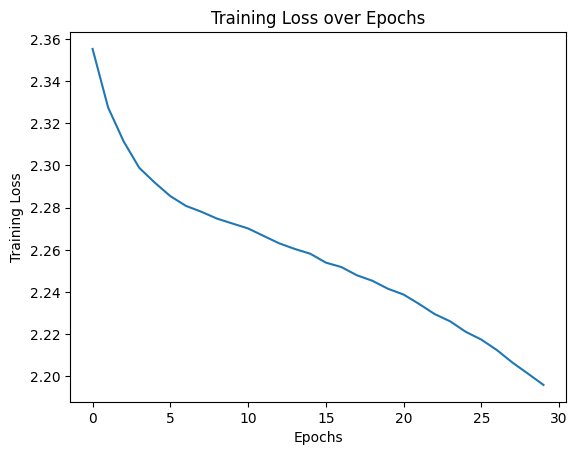

In [ ]:
#display the loss over epochs
plt.plot(train_losses)
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss over Epochs')
plt.show()



## Evaluation

Now the model is trained, we can evaluate it on the test dataset. We do that by predicting the labels using our model, and comparing it with the true labels. This allows us to compute the classification accuracy, which is provided in the function below.

<span style="color:red">**Exercice 2**</span> Evaluate the model on the test set. To do that, instanciate an MLP newtork and load the trained parameters. Then, apply the evaluation function using the test dataloader, and print the accuracy. Based on the plot above (training loss over epochs), can you suggest a way to improve the test accuracy?

In [ ]:
# Evaluation function: similar to the training loop, except we don't need to compute any gradient / backprop
def eval_mlp_classifier(model, eval_dataloader):

    # Set the model in 'evaluation' mode: this disables some layers (batch norm, dropout...) which are not needed when testing
    model.eval()

    # In evaluation phase, we don't need to compute gradients (for memory efficiency)
    with torch.no_grad():
        # initialize the total and correct number of labels to compute the accuracy
        correct_labels = 0
        total_labels = 0

        # Iterate over the dataset using the dataloader
        for images, labels in eval_dataloader:

            # Get the predicted labels
            images = images.reshape(images.shape[0], -1)
            y_predicted = model(images)

            # To get the predicted labels, we need to get the max over all possible classes
            _, label_predicted = torch.max(y_predicted.data, 1)

            # Compute accuracy: count the total number of samples, and the correct labels (compare the true and predicted labels)
            total_labels += labels.size(0)
            correct_labels += (label_predicted == labels).sum().item()

    accuracy = 100 * correct_labels / total_labels

    return accuracy

In [ ]:
class MLPClassif(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLPClassif, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out


## Influence of the activation function

We used the MLP classifier with a Sigmoid activation function, but another common choice is the [Rectified Linear Unit](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html?highlight=relu#torch.nn.ReLU). Here we investigate how it performs compared to the Sigmoid-based network.

<span style="color:red">**Exercice 3**</span> Define an MLP classifier using ReLU activation, and initialize it. Train it (plot the training loss over epochs), and compute the test accuracy. Which one (Sigmoid or ReLU) do you recommend to use?

In [ ]:
# Initialize the weights (for reproducibility)
model_relu = MLPClassif(input_size, hidden_size, num_classes)
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
        #initialize the weights (for reproducibility)
torch.manual_seed(0)
model_relu.apply(init_weights)

MLPClassif(
  (fc1): Linear(in_features=784, out_features=10, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=10, out_features=10, bias=True)
)

In [ ]:
def train_model(model, train_dataloader, num_epochs, loss_fn, learning_rate):
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    losses = []

    for epoch in range(num_epochs):
        total_loss = 0
        for images, labels in train_dataloader:
            images = images.view(images.size(0), -1)#flatten the images
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_dataloader)
        losses.append(avg_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

    return model, losses
#assuming traindataloader num_epochs loss_fn and  learningrate are defined elsewhere
model_tr, trainlosses = train_model(model_relu,train_dataloader,num_epochs, loss_fn, learning_rate)
#assuming eval_mlpclassifier and testdataloader are defined elsewhere
eval = eval_mlp_classifier(model_tr,test_dataloader)
print(eval)

Epoch [1/30], Loss: 1.8777
Epoch [2/30], Loss: 1.2146
Epoch [3/30], Loss: 0.8395
Epoch [4/30], Loss: 0.5973
Epoch [5/30], Loss: 0.4734
Epoch [6/30], Loss: 0.3957
Epoch [7/30], Loss: 0.3433
Epoch [8/30], Loss: 0.2915
Epoch [9/30], Loss: 0.2565
Epoch [10/30], Loss: 0.2280
Epoch [11/30], Loss: 0.2039
Epoch [12/30], Loss: 0.1813
Epoch [13/30], Loss: 0.1620
Epoch [14/30], Loss: 0.1476
Epoch [15/30], Loss: 0.1317
Epoch [16/30], Loss: 0.1195
Epoch [17/30], Loss: 0.1101
Epoch [18/30], Loss: 0.1010
Epoch [19/30], Loss: 0.0915
Epoch [20/30], Loss: 0.0856
Epoch [21/30], Loss: 0.0774
Epoch [22/30], Loss: 0.0737
Epoch [23/30], Loss: 0.0678
Epoch [24/30], Loss: 0.0629
Epoch [25/30], Loss: 0.0582
Epoch [26/30], Loss: 0.0559
Epoch [27/30], Loss: 0.0518
Epoch [28/30], Loss: 0.0493
Epoch [29/30], Loss: 0.0463
Epoch [30/30], Loss: 0.0444
84.0


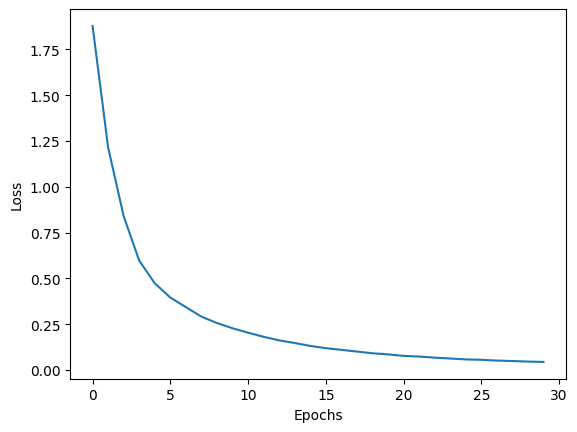

In [ ]:
# Assuming 'plt' is defined elsewhere (e.g., from matplotlib import pyplot as plt)
plt.figure()
plt.plot(trainlosses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## Increasing the model capacity

In order to improve performance, a straightforward approach is to increase the model capacity, i.e., increase the number of parameters. There are basically two ways to do so: either increase the number of neurons in each layer (*width*) of increase the total number of layers (*depth*). Let's focus here on width.

<span style="color:red">**Exercice 4**</span> For each value of `hidden_size` in $[5, 10, 100, 200]$:
- instanciate (and initialize) an MLP classifier (it uses a ReLU activation)
- train the network (same training setup as before)
- print the number of parameters
- compute and display the test accuracy

Which value of `hidden_size` would you use and why?

Epoch [1/30], Loss: 2.0148
Epoch [2/30], Loss: 1.5425
Epoch [3/30], Loss: 1.2895
Epoch [4/30], Loss: 1.0904
Epoch [5/30], Loss: 0.9010
Epoch [6/30], Loss: 0.7759
Epoch [7/30], Loss: 0.6888
Epoch [8/30], Loss: 0.6307
Epoch [9/30], Loss: 0.5916
Epoch [10/30], Loss: 0.5339
Epoch [11/30], Loss: 0.4936
Epoch [12/30], Loss: 0.4641
Epoch [13/30], Loss: 0.4367
Epoch [14/30], Loss: 0.4146
Epoch [15/30], Loss: 0.3826
Epoch [16/30], Loss: 0.3711
Epoch [17/30], Loss: 0.3445
Epoch [18/30], Loss: 0.3318
Epoch [19/30], Loss: 0.3092
Epoch [20/30], Loss: 0.2959
Epoch [21/30], Loss: 0.2803
Epoch [22/30], Loss: 0.2658
Epoch [23/30], Loss: 0.2524
Epoch [24/30], Loss: 0.2414
Epoch [25/30], Loss: 0.2316
Epoch [26/30], Loss: 0.2210
Epoch [27/30], Loss: 0.2089
Epoch [28/30], Loss: 0.1990
Epoch [29/30], Loss: 0.1947
Epoch [30/30], Loss: 0.1909
Number of parameters for hidden_size=5: 3985
Test accuracy for hidden_size=5: 80.00%


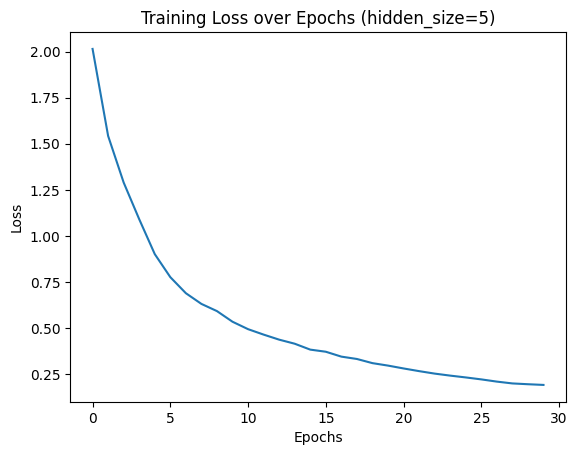

Epoch [1/30], Loss: 1.8777
Epoch [2/30], Loss: 1.2146
Epoch [3/30], Loss: 0.8395
Epoch [4/30], Loss: 0.5973
Epoch [5/30], Loss: 0.4734
Epoch [6/30], Loss: 0.3957
Epoch [7/30], Loss: 0.3433
Epoch [8/30], Loss: 0.2915
Epoch [9/30], Loss: 0.2565
Epoch [10/30], Loss: 0.2280
Epoch [11/30], Loss: 0.2039
Epoch [12/30], Loss: 0.1813
Epoch [13/30], Loss: 0.1620
Epoch [14/30], Loss: 0.1476
Epoch [15/30], Loss: 0.1317
Epoch [16/30], Loss: 0.1195
Epoch [17/30], Loss: 0.1101
Epoch [18/30], Loss: 0.1010
Epoch [19/30], Loss: 0.0915
Epoch [20/30], Loss: 0.0856
Epoch [21/30], Loss: 0.0774
Epoch [22/30], Loss: 0.0737
Epoch [23/30], Loss: 0.0678
Epoch [24/30], Loss: 0.0629
Epoch [25/30], Loss: 0.0582
Epoch [26/30], Loss: 0.0559
Epoch [27/30], Loss: 0.0518
Epoch [28/30], Loss: 0.0493
Epoch [29/30], Loss: 0.0463
Epoch [30/30], Loss: 0.0444
Number of parameters for hidden_size=10: 7960
Test accuracy for hidden_size=10: 84.00%


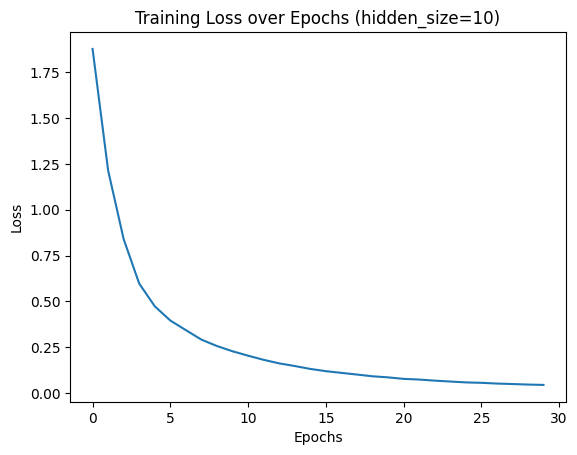

Epoch [1/30], Loss: 1.3781
Epoch [2/30], Loss: 0.5371
Epoch [3/30], Loss: 0.3491
Epoch [4/30], Loss: 0.2522
Epoch [5/30], Loss: 0.1991
Epoch [6/30], Loss: 0.1563
Epoch [7/30], Loss: 0.1317
Epoch [8/30], Loss: 0.1078
Epoch [9/30], Loss: 0.0887
Epoch [10/30], Loss: 0.0764
Epoch [11/30], Loss: 0.0662
Epoch [12/30], Loss: 0.0572
Epoch [13/30], Loss: 0.0520
Epoch [14/30], Loss: 0.0462
Epoch [15/30], Loss: 0.0417
Epoch [16/30], Loss: 0.0388
Epoch [17/30], Loss: 0.0353
Epoch [18/30], Loss: 0.0319
Epoch [19/30], Loss: 0.0298
Epoch [20/30], Loss: 0.0276
Epoch [21/30], Loss: 0.0260
Epoch [22/30], Loss: 0.0243
Epoch [23/30], Loss: 0.0227
Epoch [24/30], Loss: 0.0215
Epoch [25/30], Loss: 0.0205
Epoch [26/30], Loss: 0.0193
Epoch [27/30], Loss: 0.0184
Epoch [28/30], Loss: 0.0176
Epoch [29/30], Loss: 0.0167
Epoch [30/30], Loss: 0.0161
Number of parameters for hidden_size=100: 79510
Test accuracy for hidden_size=100: 92.00%


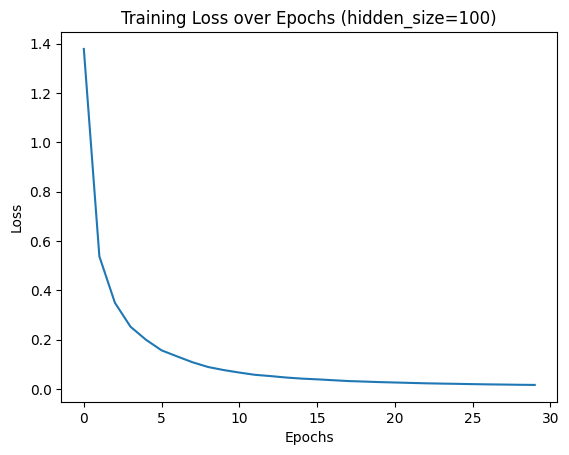

Epoch [1/30], Loss: 1.1656
Epoch [2/30], Loss: 0.4670
Epoch [3/30], Loss: 0.3010
Epoch [4/30], Loss: 0.2204
Epoch [5/30], Loss: 0.1647
Epoch [6/30], Loss: 0.1324
Epoch [7/30], Loss: 0.1043
Epoch [8/30], Loss: 0.0857
Epoch [9/30], Loss: 0.0719
Epoch [10/30], Loss: 0.0624
Epoch [11/30], Loss: 0.0537
Epoch [12/30], Loss: 0.0482
Epoch [13/30], Loss: 0.0428
Epoch [14/30], Loss: 0.0383
Epoch [15/30], Loss: 0.0350
Epoch [16/30], Loss: 0.0317
Epoch [17/30], Loss: 0.0294
Epoch [18/30], Loss: 0.0275
Epoch [19/30], Loss: 0.0258
Epoch [20/30], Loss: 0.0240
Epoch [21/30], Loss: 0.0223
Epoch [22/30], Loss: 0.0209
Epoch [23/30], Loss: 0.0199
Epoch [24/30], Loss: 0.0189
Epoch [25/30], Loss: 0.0180
Epoch [26/30], Loss: 0.0169
Epoch [27/30], Loss: 0.0161
Epoch [28/30], Loss: 0.0153
Epoch [29/30], Loss: 0.0149
Epoch [30/30], Loss: 0.0141
Number of parameters for hidden_size=200: 159010
Test accuracy for hidden_size=200: 90.00%


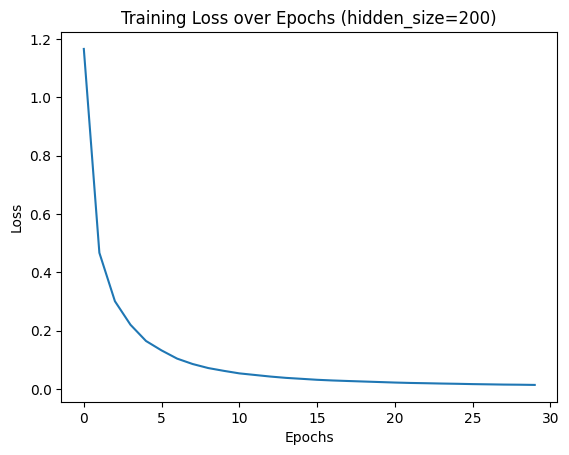

In [ ]:
# instanciate (and initialize) an MLP classifier (it uses a ReLU activation)
hidden_sizes = [5, 10, 100, 200]
for hidden_size in hidden_sizes:
    model_relu = MLPClassif(input_size, hidden_size, num_classes)
    torch.manual_seed(0)
    model_relu.apply(init_weights)
    model_tr, train_losses = train_model(model_relu, train_dataloader, num_epochs, loss_fn, learning_rate)
    print(f"Number of parameters for hidden_size={hidden_size}: {sum(p.numel() for p in model_relu.parameters())}")
    test_accuracy = eval_mlp_classifier(model_tr, test_dataloader)
    print(f"Test accuracy for hidden_size={hidden_size}: {test_accuracy:.2f}%")

    plt.figure()
    plt.plot(train_losses)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training Loss over Epochs (hidden_size={hidden_size})')
    plt.show()
